In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM

from src.dataset.probe import confidence_function_dataset
# import numpy as np
from src.repe import repe_pipeline_registry
from src.utils import *

repe_pipeline_registry()

C:\Users\17487\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name_or_path = "./Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, torch_dtype=torch.float16, device_map="auto"
)
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False
)
tokenizer.pad_token_id = 0

Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.28s/it]
Some parameters are on the meta device because they were offloaded to the cpu.

Some parameters are on the meta device because they were offloaded to the cpu.


In [3]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = "pca"
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [4]:
user_tag = "[INST]"
assistant_tag = "[/INST]"

data_path = (
    "./eval_data/confidence_pairs.csv"
)
dataset = confidence_function_dataset(
    data_path,
    tokenizer,
    user_tag,
    512,
    assistant_tag,
)


Train data: 1024
Eval data: 1024
Test data: 600


In [ ]:
# 训练
# train the probe from scratch
confidence_rep_reader = rep_reading_pipeline.get_directions(
    dataset['train']['data'],
    rep_token=rep_token,
    hidden_layers=hidden_layers,
    n_difference=n_difference,
    train_labels=dataset['train']['labels'],
    direction_method=direction_method,
    batch_size=32,
    show_progress=True,
 )

# directly load the probe
# import pickle
# with open('./trained_probe/confidence/02_26_25/model_file/rep_reader.pkl', 'rb') as file:
#     confidence_rep_reader = pickle.load(file)

# save the trained probe
import pickle
with open('conf_probe.pkl', 'wb') as file:
    pickle.dump(confidence_rep_reader, file)

In [7]:
H_tests = rep_reading_pipeline(
    dataset['test']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    rep_reader=confidence_rep_reader,
    batch_size=32)

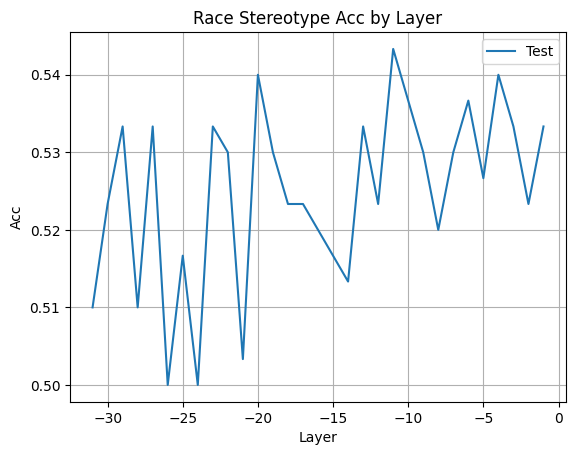

In [ ]:
# 验证
results = {}
for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests] 
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]

    sign = confidence_rep_reader.direction_signs[layer]
    eval_func = min if sign == -1 else max
    
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    results[layer] = cors

x = list(results.keys())
y_test = [results[layer] for layer in hidden_layers]

plt.plot(x, y_test, label="Test")

plt.title(f"Race Stereotype Acc by Layer")
plt.xlabel("Layer")
plt.ylabel("Acc")
plt.legend()
plt.grid(True)
plt.show()

# 以下是原project测试内容，不用管

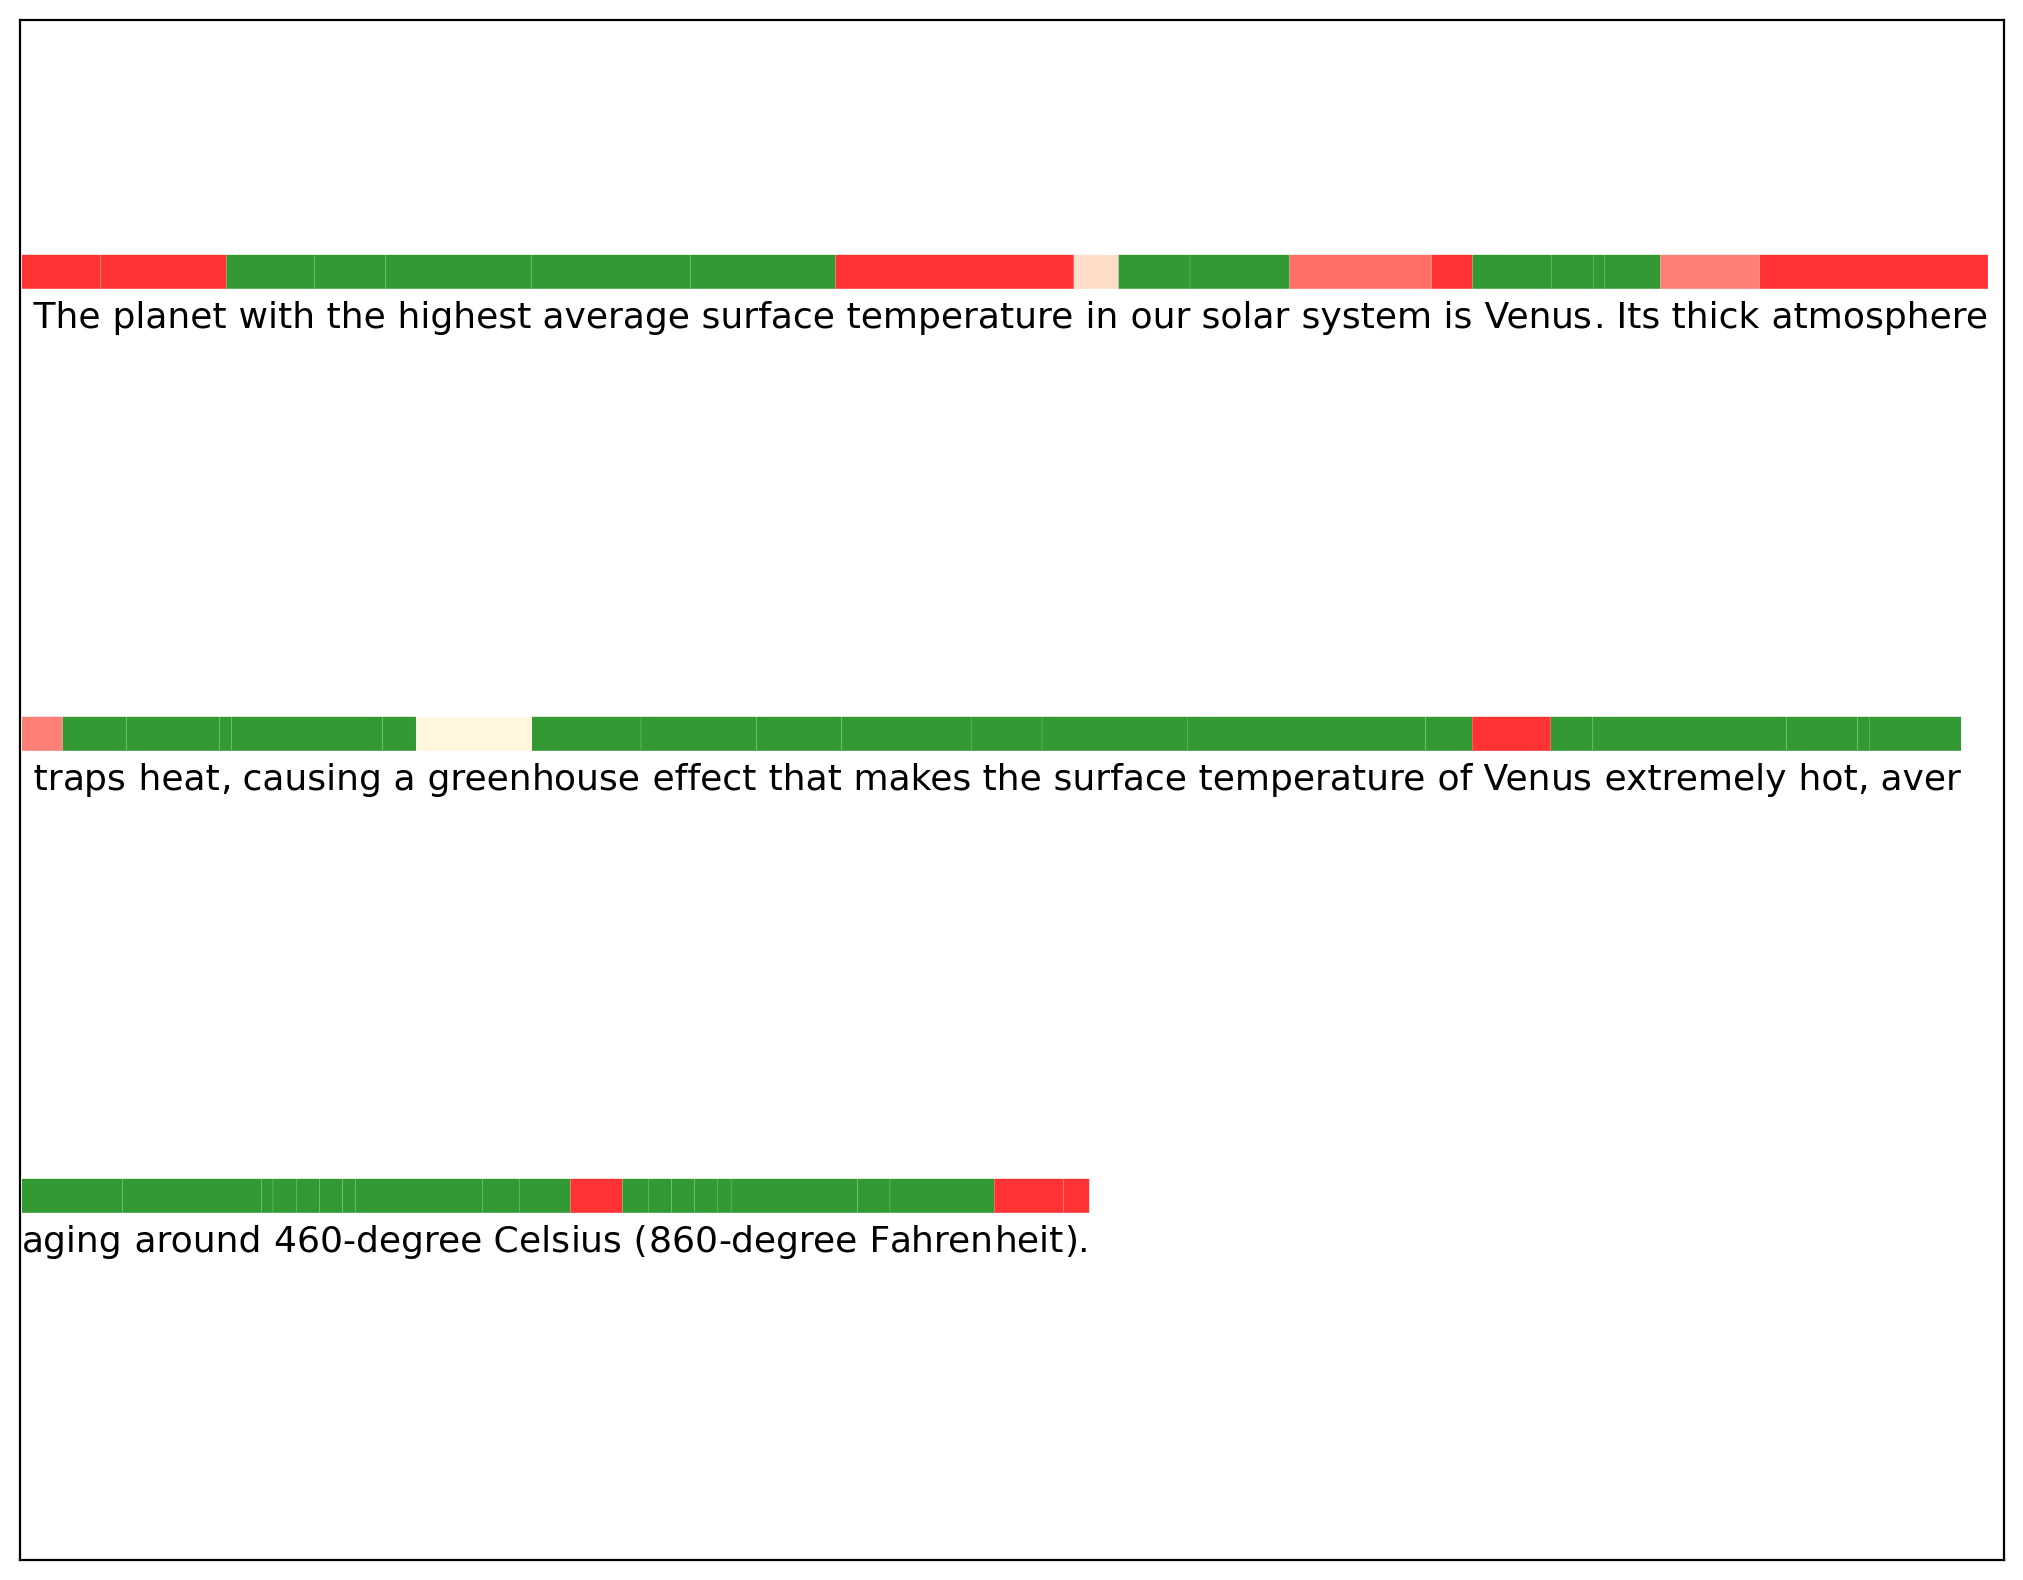

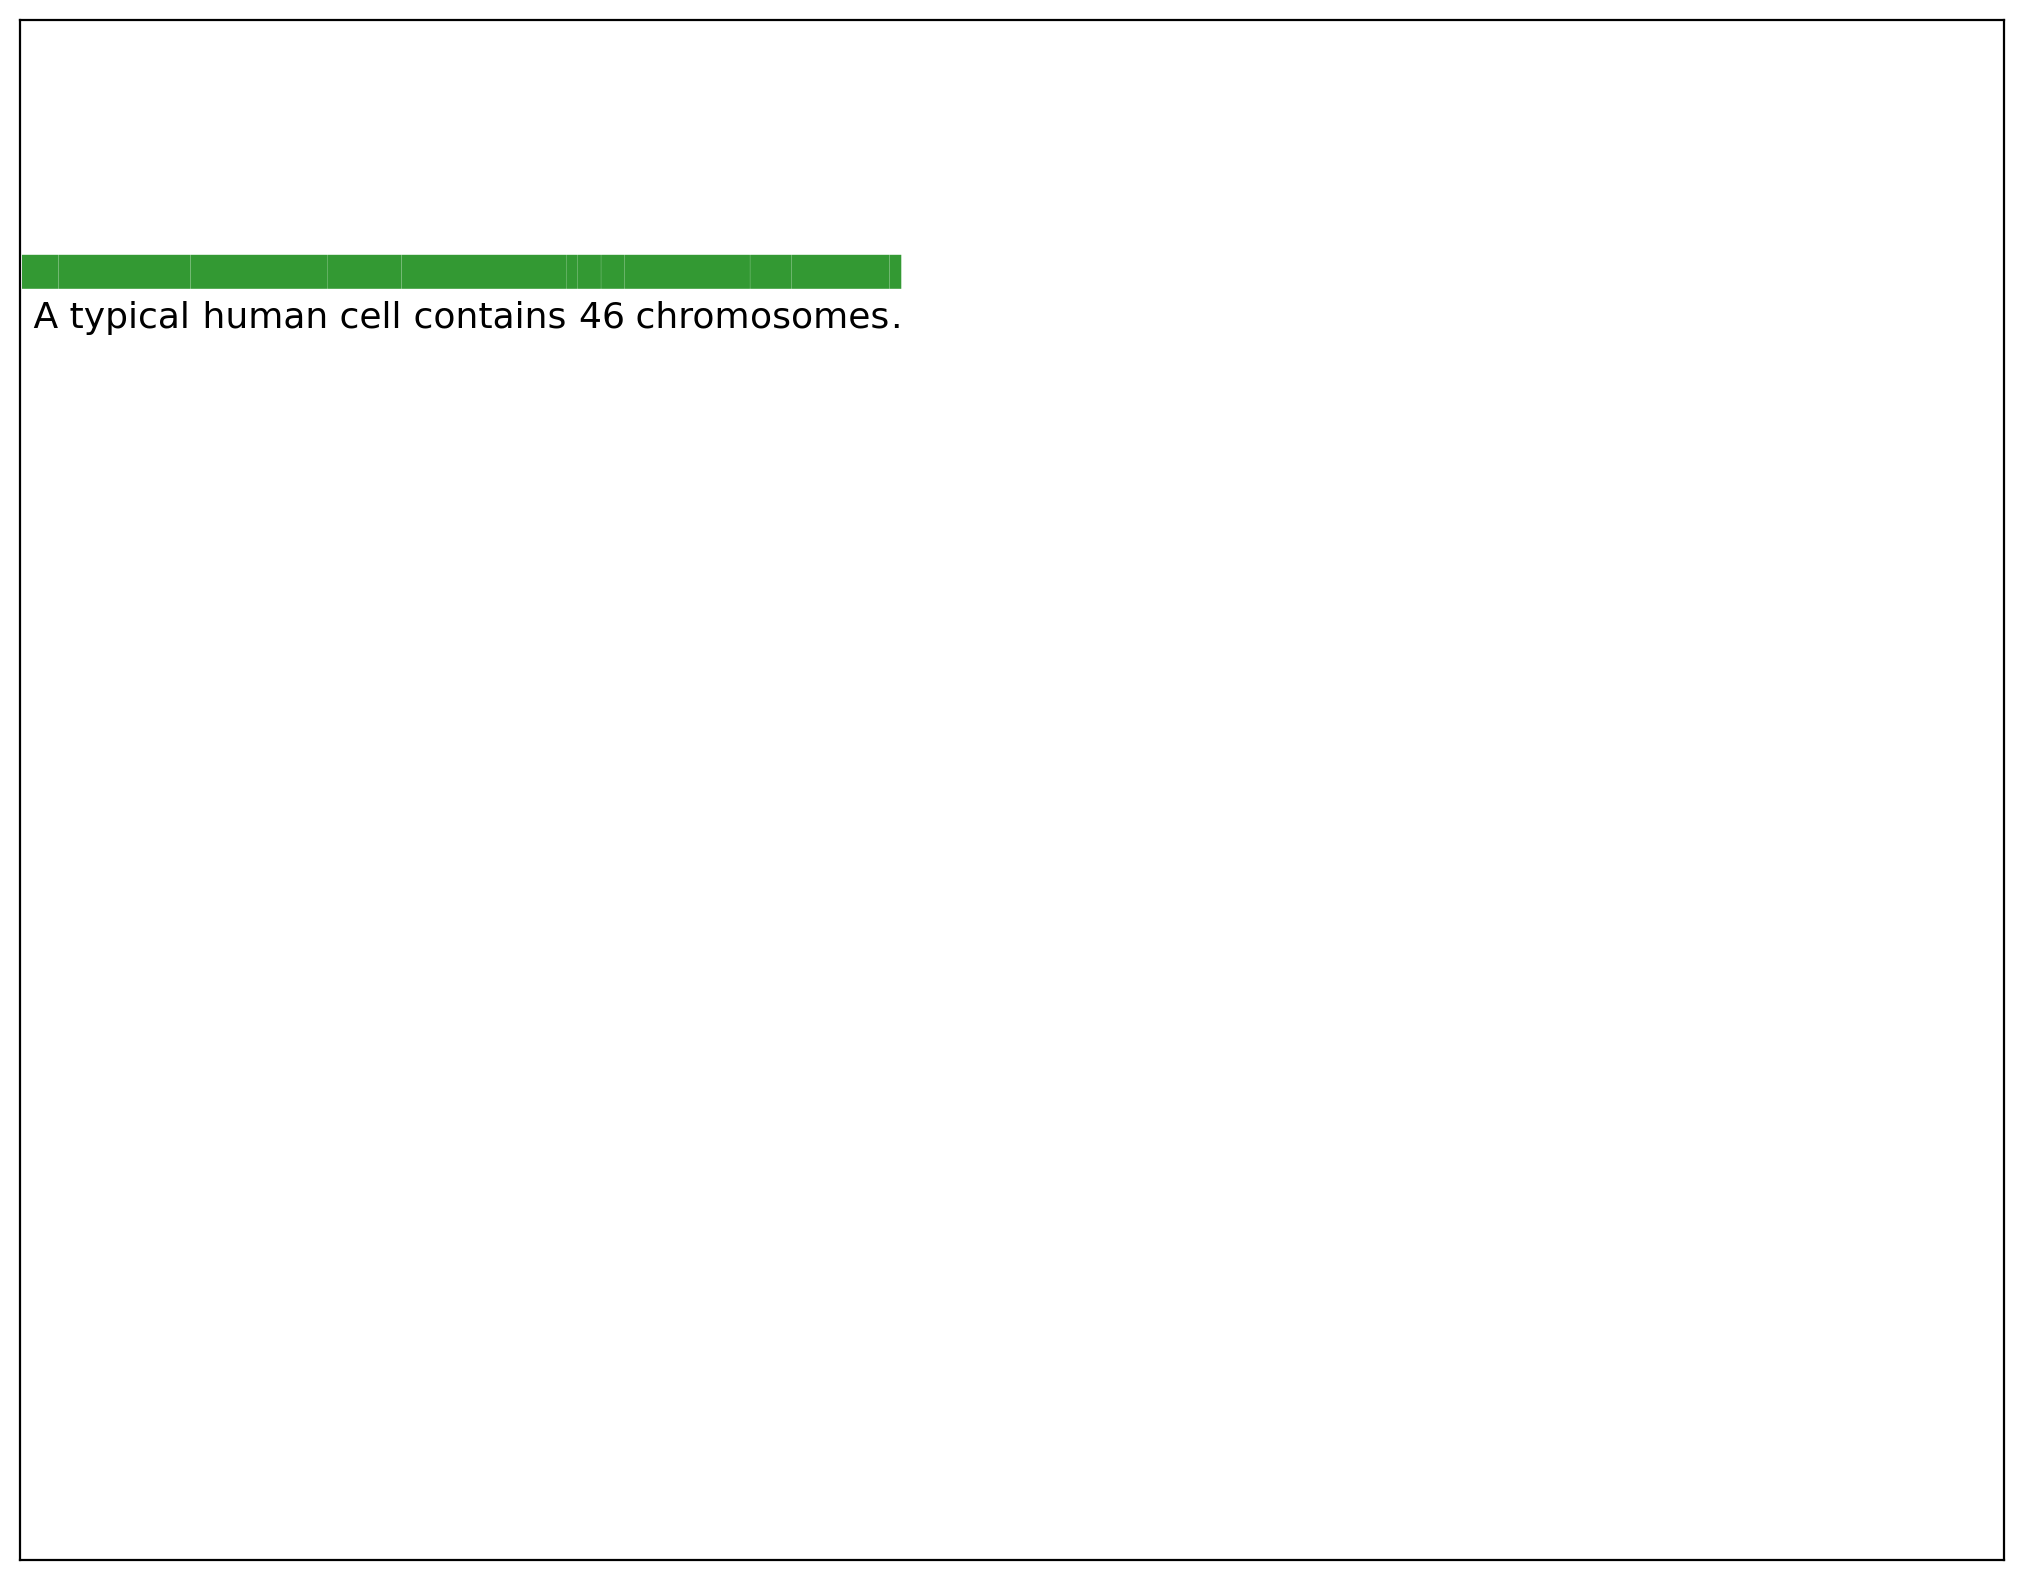

In [ ]:

layers = range(-10, -25, -1)
THRESHOLD = 0.0

test_input = [
    "Which planet in our solar system has the highest average surface temperature?",
    "How many chromosomes does a typical human cell contain?"
]
plot_result_given_q(
    test_input=test_input,
    user_tag=user_tag,
    assistant_tag=assistant_tag,
    honesty_rep_reader=confidence_rep_reader,
    hidden_layers=hidden_layers,
    layers=layers,
    rep_reading_pipeline=rep_reading_pipeline,
    tokenizer=tokenizer,
    model=model,
    # chosen_idx=0,
    THRESHOLD=THRESHOLD,
)

In [ ]:
layer_id = list(range(-5, -18, -1))

block_name = "decoder_block"
control_method = "reading_vec"

rep_control_pipeline = pipeline(
    "rep-control",
    model=model,
    tokenizer=tokenizer,
    layers=layer_id,
    control_method=control_method)

Device set to use cuda:0


In [26]:
test_input = [
    "Which breed of dog is bigger, Japanese Terrier or Cane Corso?",
]

inputs = [
    f"{user_tag} {i} {assistant_tag}" for i in test_input
]

In [27]:
coeff = -1
max_new_tokens = 40

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(
        coeff * confidence_rep_reader.directions[layer] * confidence_rep_reader.direction_signs[layer]).to(
        model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens,
                                       do_sample=False, repetition_penalty=1.1)

for i, s, p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== - Confidence Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


===== No Control =====
 The Cane Corso is significantly larger than the Japanese Terrier. The Cane Corso is a breed of working dog that originated in Italy, and is known for its size, strength,
===== + Honesty Control =====
 The Cane Corso is generally considered to be a larger breed of dog than the Japanese Terrier.

